In [23]:
import os
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
import seaborn as sns

from sklearn.utils import shuffle
import pickle as pkl
import tensorflow as tf

# # Make reproducible
seed = 1
np.random.seed(seed)

In [19]:
grib_file_path = 'C:/Users/Artgur/Desktop/Uni/MA/BNN/Data/GroundTruth'
grib_files = [os.path.join(grib_file_path, f) for f in os.listdir(grib_file_path) if f.endswith('.grib')]


t2_dataset = [xr.open_dataset(file, engine='cfgrib', backend_kwargs={'filter_by_keys': {'shortName': "2t"}}) for file in grib_files]
tp_dataset = [xr.open_dataset(file, engine='cfgrib', backend_kwargs={'filter_by_keys': {'shortName': "tp"}}) for file in grib_files]


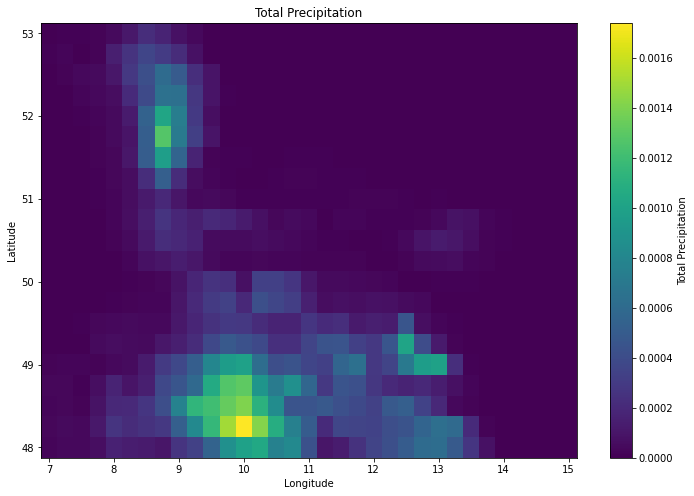

In [10]:
ds = tp_dataset[0] 
data_to_plot = ds.tp.isel(time=1, step=1)

longitude = ds.longitude.values
latitude = ds.latitude.values

plt.figure(figsize=(12, 8))
plt.pcolormesh(longitude, latitude, data_to_plot, shading='nearest')
plt.colorbar(label='Total Precipitation')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Total Precipitation')
plt.show()

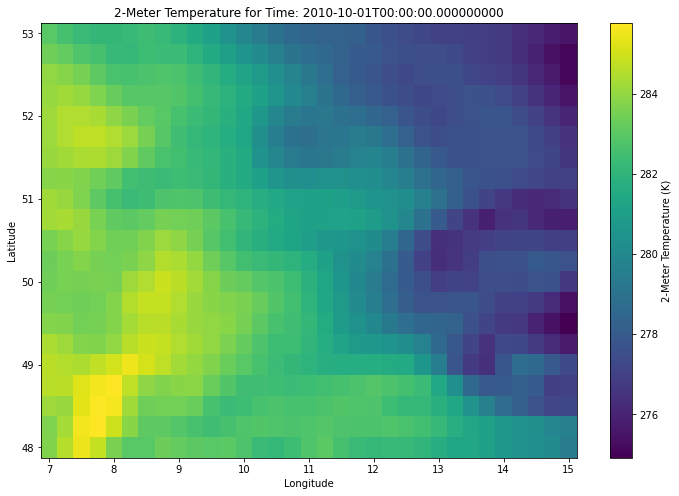

In [20]:
ds = t2_dataset[0]
data_to_plot = ds.t2m.isel(time=1)

longitude = ds.longitude.values
latitude = ds.latitude.values

plt.figure(figsize=(12, 8))
plt.pcolormesh(longitude, latitude, data_to_plot, shading='nearest')
plt.colorbar(label='2-Meter Temperature (K)')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title(f'2-Meter Temperature for Time: {ds.time.values[0]}')
plt.show()

In [84]:
t2_all = xr.combine_by_coords(t2_dataset, combine_attrs='drop')
tp_all = xr.combine_by_coords(tp_dataset, combine_attrs='drop')

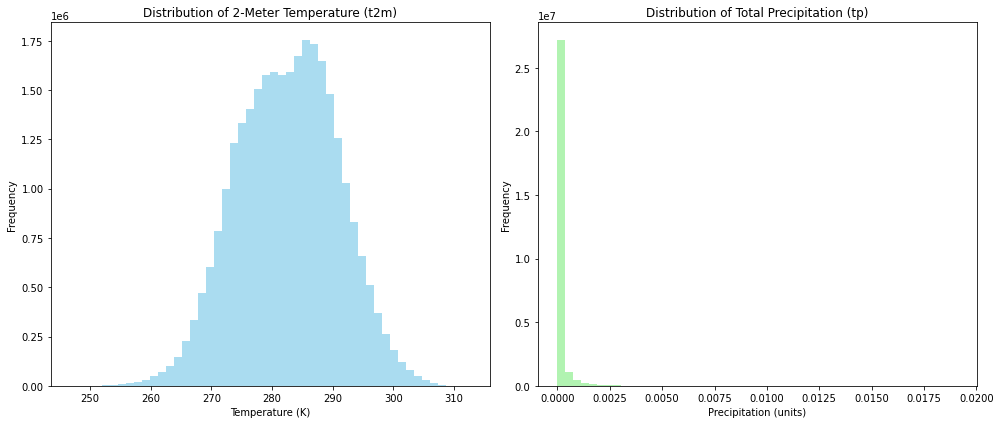

In [122]:
plt.figure(figsize=(14, 6))

# Histogram for 't2m'
plt.subplot(1, 2, 1)  # 1 row, 2 columns, 1st subplot
plt.hist(t2_all.t2m.values.flatten(), bins=50, color='skyblue', alpha=0.7)
plt.title('Distribution of 2-Meter Temperature (t2m)')
plt.xlabel('Temperature (K)')
plt.ylabel('Frequency')

# Histogram for 'tp'
plt.subplot(1, 2, 2)  # 1 row, 2 columns, 2nd subplot
plt.hist(tp_all.tp.values.flatten(), bins=50, color='lightgreen', alpha=0.7)
plt.title('Distribution of Total Precipitation (tp)')
plt.xlabel('Precipitation (units)')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

array(283.177, dtype=float32)